In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install -r ../requirements.txt

In [ ]:
!pip install torch

In [1]:
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import PIL.Image as pil_image

from models import RDN

import pandas as pd
import os

from utils import convert_rgb_to_y, denormalize, calc_psnr

In [2]:
def test(weights_file, image_file, num_features=64, growth_rate=64, num_blocks=16, num_layers=8, scale=4):
    cudnn.benchmark = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model = RDN(scale_factor=scale,
                num_channels=3,
                num_features=num_features,
                growth_rate=growth_rate,
                num_blocks=num_blocks,
                num_layers=num_layers).to(device)

    state_dict = model.state_dict()
    for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
        if n in state_dict.keys():
            state_dict[n].copy_(p)
        else:
            raise KeyError(n)

    model.eval()

    image = pil_image.open(image_file).convert('RGB')

    image_width = (image.width // scale) * scale
    image_height = (image.height // scale) * scale

    hr = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
    lr = hr.resize((hr.width // scale, hr.height // scale), resample=pil_image.BICUBIC)
    bicubic = lr.resize((lr.width * scale, lr.height * scale), resample=pil_image.BICUBIC)
    bicubic.save(image_file.replace('.png', '_bicubic_x{}.png'.format(scale)))

    lr = np.expand_dims(np.array(lr).astype(np.float32).transpose([2, 0, 1]), 0) / 255.0
    hr = np.expand_dims(np.array(hr).astype(np.float32).transpose([2, 0, 1]), 0) / 255.0
    lr = torch.from_numpy(lr).to(device)
    hr = torch.from_numpy(hr).to(device)

    with torch.no_grad():
        preds = model(lr).squeeze(0)

    preds_y = convert_rgb_to_y(denormalize(preds), dim_order='chw')
    hr_y = convert_rgb_to_y(denormalize(hr.squeeze(0)), dim_order='chw')

    preds_y = preds_y[scale:-scale, scale:-scale]
    hr_y = hr_y[scale:-scale, scale:-scale]

    psnr = calc_psnr(hr_y, preds_y)
#     print('PSNR: {:.2f}'.format(psnr))

    output = pil_image.fromarray(denormalize(preds).permute(1, 2, 0).byte().cpu().numpy())
    output.save(image_file.replace('.png', '_rdn_x{}.png'.format(scale)))
    
    return {
        "test_set" : image_file.split("/")[1],
        "psnr" : psnr.item()
    }

In [3]:
models_dir = "../rdn-results/outputs/x4/"
images_dir = ["../BSDS100/", "../Set5/", "../Set14/", "../Urban100/"]

In [4]:
test_images = {}
for test_dir in images_dir:
    f = []
    for (dirpath, dirnames, filenames) in os.walk(test_dir):
        f.extend(filenames)
        break
    test_images[test_dir.split("/")[1]] = f

In [5]:
test_images

{'BSDS100': ['19021.png',
  '97033.png',
  '21077.png',
  '304074.png',
  '253027.png',
  '38082.png',
  '58060.png',
  '175043.png',
  '102061.png',
  '42049.png',
  '167083.png',
  '106024.png',
  '208001.png',
  '216081.png',
  '41069.png',
  '119082.png',
  '304034.png',
  '3096.png',
  '229036.png',
  '285079.png',
  '105025.png',
  '8023.png',
  '385039.png',
  '43074.png',
  '69040.png',
  '69015.png',
  '108082.png',
  '220075.png',
  '86068.png',
  '159008.png',
  '126007.png',
  '163085.png',
  '300091.png',
  '197017.png',
  '236037.png',
  '253055.png',
  '101085.png',
  '62096.png',
  '38092.png',
  '103070.png',
  '42012.png',
  '86016.png',
  '130026.png',
  '85048.png',
  '108070.png',
  '296059.png',
  '109053.png',
  '160068.png',
  '148026.png',
  '189080.png',
  '134035.png',
  '37073.png',
  '223061.png',
  '299086.png',
  '175032.png',
  '86000.png',
  '170057.png',
  '291000.png',
  '210088.png',
  '143090.png',
  '69020.png',
  '219090.png',
  '76053.png',
  '78

In [6]:
five_up = {}
for i in test_images.keys():
    five_up[i] = test_images[i][:5]
five_up

{'BSDS100': ['19021.png',
  '97033.png',
  '21077.png',
  '304074.png',
  '253027.png'],
 'Set14': ['pepper.png',
  'man.png',
  'ppt3.png',
  'bridge.png',
  'coastguard.png'],
 'Set5': ['bird.png', 'head.png', 'woman.png', 'butterfly.png', 'baby.png'],
 'Urban100': ['img_063.png',
  'img_098.png',
  'img_008.png',
  'img_086.png',
  'img_002.png']}

In [7]:
pd.DataFrame(five_up)

,BSDS100,Set14,Set5,Urban100
0,19021.png,pepper.png,bird.png,img_063.png
1,97033.png,man.png,head.png,img_098.png
2,21077.png,ppt3.png,woman.png,img_008.png
3,304074.png,bridge.png,butterfly.png,img_086.png
4,253027.png,coastguard.png,baby.png,img_002.png


In [8]:
### get best model 
log_name = "base.log"
train_log = open("../rdn-results/logs/" + log_name)
train_log_arr = [i for i in train_log.read().split("\n") if i]

best_epoch = int(train_log_arr[-1].split(",")[0].split(":")[1])
train_log_arr[best_epoch]

ValueError: invalid literal for int() with base 10: ' 30.19'

In [9]:
# display learning chart 

In [10]:
def create_dict_from_train_log(line):
    arr = line.split(":")
    
    return {arr[0] : float(arr[1])}
    

In [11]:
def process_train_loss_line(line):
    loss_arr = line.split("[")[-1].split(", ")[-1].replace("]", "").split("=")
    epoch = line.split(":")[1].split("/")[0]
    
    return {"epoch" : epoch, loss_arr[0] : float(loss_arr[1])}
    
    

### parse the training log copied from std output during training 

In [12]:
train_log_loss = open("../rdn-results/logs/train-loss.log")
train_log_loss_arr = [process_train_loss_line(i) for i in train_log_loss.read().split("\n") if "epoch" in i]
df_train_loss = pd.DataFrame(train_log_loss_arr)
df_train_loss.head()

,epoch,loss
0,0,0.068386
1,1,0.035733
2,2,0.033469
3,3,0.031551
4,4,0.031076


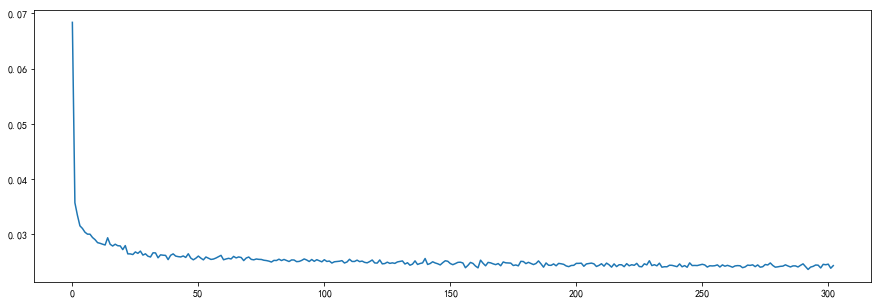

In [15]:
df_train_loss["loss"].plot(figsize=(15, 5))

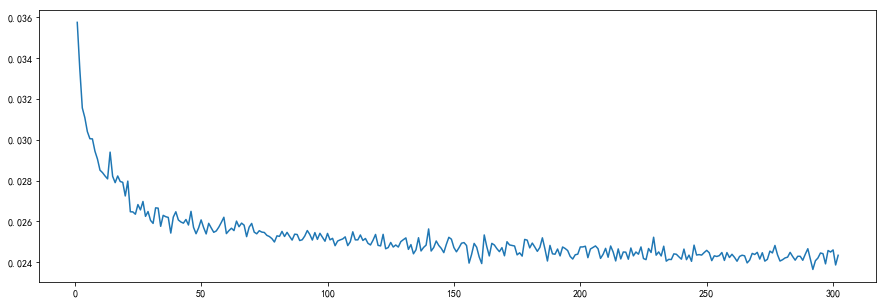

In [14]:
df_train_loss[df_train_loss["loss"] < .04]["loss"].plot(figsize=(15, 5))

In [16]:
train_log_dicts = [ create_dict_from_train_log(i) for i in train_log_arr[:-1]]

In [17]:
train_df = pd.DataFrame(train_log_dicts)
train_df.head()

,eval psnr
0,28.01
1,28.84
2,29.03
3,29.09
4,28.99


### progression of psnr across epochs

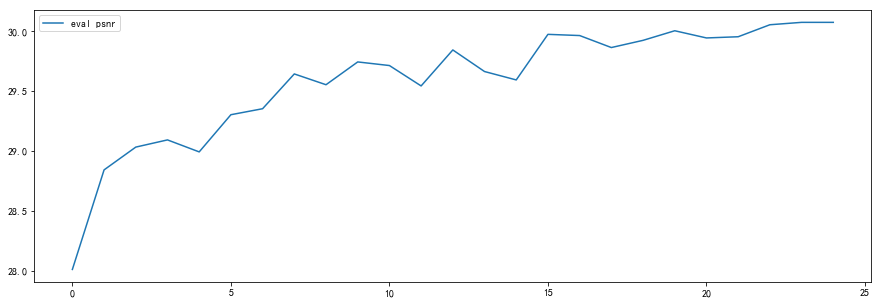

In [18]:
train_df.plot(figsize=(15, 5))

In [19]:
weights_file = models_dir + "best.pth"

os.path.isfile(weights_file), weights_file

(False, '../rdn-results/outputs/x4/best.pth')

In [ ]:
test_results = []
if os.path.isfile(weights_file):
    for key in test_images.keys():
        max_images = 0
        print ("testing " + key)
        for image in test_images[key]:
            if not ("_rdn_x4" in image or "_bicubic_x" in image):
                image_file = "../" + key + "/" + image
                print("\t" +  image )
                test_results.append(test(weights_file, image_file))
            

In [ ]:
def get_test_report(array_of_dicts, dataset):
    this_arr = [i for i in array_of_dicts if dataset == i["test_set"] ]
    return pd.DataFrame(this_arr)

In [ ]:
import json 

with open("../rdn-results/logs/test-results.json", mode='w', encoding='utf-8') as f:
    json.dump(test_results, f)


In [ ]:
stats_BSDS100 = get_test_report(test_results, "BSDS100")

In [ ]:
stats_BSDS100["psnr"].describe()

In [ ]:
stats_BSDS100.plot.bar(figsize=(20,5))

In [ ]:
stats_Set5 = get_test_report(test_results, "Set5")
stats_Set5.describe()

In [ ]:
stats_Set5.plot.bar(figsize = (15,5))

In [ ]:
stats_Set14 = get_test_report(test_results, "Set14")
stats_Set14.describe()

In [ ]:
stats_Set14.plot.bar(figsize = (15,5))

In [ ]:
stats_Urban100 = get_test_report(test_results, "Urban100")
stats_Urban100.describe()

In [ ]:
stats_Urban100.plot.bar(figsize = (15,5))